# Building a Solar Panel Detector

Author: Shardul Junagade

Date: 27 February 2026

In this notebook, we will build a solar panel detector that can detect solar panels in aerial images.

### Importing Libraries

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Retina display
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Data Exploration and Understanding

We will use the [Solar Panel Object Labels dataset from Figshare](https://figshare.com/articles/dataset/Solar_Panel_Object_Labels/22081091). This dataset contains high-resolution aerial images with labeled solar panels. We will use the 31 cm native resolution images of sizes 416x416 pixels for our analysis.

The dataset files follow a specific naming structure: `solarpanels_native_<image_number>__x0_<x_coordinate>_y0_<y_coordinate>_dxdy_<size>`.

For example, in the file `solarpanels_native_1__x0_0_y0_6845_dxdy_416.txt`:

- `solarpanels_native`: Indicates that the file contains solar panel data in native resolution.
- `<image_number>`: The number of the image in the dataset.
- `x0_<x_coordinate>`: The x-coordinate of the top-left corner of the image.
- `y0_<y_coordinate>`: The y-coordinate of the top-left corner of the image.
- `dxdy_<size>`: The size of the image in pixels (both width and height).

Each line in the file represents a detected solar panel with the following format: `category x_center y_center width height`, where:

- `category`: The category label (0 for solar panels).
- `x_center`: The x-coordinate of the center of the bounding box (normalized).
- `y_center`: The y-coordinate of the center of the bounding box (normalized).
- `width`: The width of the bounding box (normalized).
- `height`: The height of the bounding box (normalized).


In [44]:
image_dir = 'data/images_native/'
label_dir = 'data/labels_native/'
image_size = 416
meters_per_pixel = 0.31  # meters per pixel

In [ ]:
image_names = sorted([image_name for image_name in os.listdir(image_dir) if image_name.endswith('.tif')])
label_names = sorted([label_name for label_name in os.listdir(label_dir) if label_name.endswith('.txt')])

print('Number of images:', len(image_names))
print('Number of labels:', len(label_names))

Number of images: 2553
Number of labels: 2542


The number of images and the number of labels is not the same. So, we can remove the images that do not have corresponding labels and remove the labels that do not have corresponding images.

In [37]:
# delete the images that do not have corresponding labels
for image_name in image_names:
    if image_name.replace('.tif', '.txt') not in label_names:
        os.remove(image_dir + image_name)

# delete the labels that do not have corresponding images
for label_name in label_names:
    if label_name.replace('.txt', '.tif') not in image_names:
        os.remove(label_dir + label_name)

image_names = sorted([image_name for image_name in os.listdir(image_dir) if image_name.endswith('.tif')])
label_names = sorted([label_name for label_name in os.listdir(label_dir) if label_name.endswith('.txt')])

print('Number of images:', len(image_names))
print('Number of labels:', len(label_names))

Number of images: 2542
Number of labels: 2542


### Dataset Statistics

In [ ]:
total_instances = 0
class_count = {}

for label_name in label_names:
    label_path = os.path.join(label_dir, label_name)

    with open(label_path, 'r') as f:
        lines = f.readlines()
        total_instances += len(lines)
        for line in lines:
            class_name = line.split()[0]
            class_count[class_name] = class_count.get(class_name, 0) + 1

class_count = dict(sorted(class_count.items()))

print('Total instances:', total_instances)
print('\nNumber of unique classes:', len(class_count))
print('\nClass-wise distribution:')
for class_name, count in class_count.items():
    print(f'    Class {class_name}: {count}')

Total instances: 29625

Number of unique classes: 3

Class-wise distribution:
    Class 0: 29267
    Class 1: 130
    Class 2: 228


In [ ]:
# Calculate number of images having a particular number of labels
label_distribution = {}
for label_name in label_names:
    label_path = os.path.join(label_dir, label_name)
    with open(label_path, 'r') as f:
        lines = f.readlines()
        num_labels = len(lines)
        label_distribution[num_labels] = label_distribution.get(num_labels, 0) + 1

label_distribution = dict(sorted(label_distribution.items()))
print('Value counts of labels per image:')
for num_labels, count in label_distribution.items():
    print(f'{count} images have {num_labels} labels.')

Value counts of labels per image:
81 images have 1 labels.
167 images have 2 labels.
221 images have 3 labels.
218 images have 4 labels.
217 images have 5 labels.
189 images have 6 labels.
170 images have 7 labels.
184 images have 8 labels.
169 images have 9 labels.
121 images have 10 labels.
97 images have 11 labels.
84 images have 12 labels.
69 images have 13 labels.
49 images have 14 labels.
46 images have 15 labels.
41 images have 16 labels.
36 images have 17 labels.
25 images have 18 labels.
29 images have 19 labels.
14 images have 20 labels.
4 images have 21 labels.
1 images have 22 labels.
4 images have 23 labels.
2 images have 24 labels.
4 images have 25 labels.
3 images have 26 labels.
5 images have 27 labels.
5 images have 28 labels.
15 images have 29 labels.
20 images have 30 labels.
8 images have 31 labels.
7 images have 32 labels.
13 images have 33 labels.
19 images have 34 labels.
10 images have 35 labels.
6 images have 36 labels.
17 images have 37 labels.
13 images have 

### Area of Solar Panels

We can calculate the area of the solar panels (in square meters) as follows:

1. **Denormalize x-width and y-width:**
    - Multiply by the chip size:
      - Native resolution (31 cm): $416 \times 416$
      - HD resolution (15.5 cm): $832 \times 832$

2. **Convert to real-world meters:**
    - Pixel size = 0.31 meters per pixel
    - Real width & height in meters:
      $$
      \text{real\_width} = x\_width \times 416 \times 0.31
      $$
      $$
      \text{real\_height} = y\_width \times 416 \times 0.31
      $$

3. **Compute area:**
    $$
    \text{area} = \text{real\_width} \times \text{real\_height}
    $$



Mean area of solar panels: 191.52 m^2
Standard deviation of area of solar panels: 630.70 m^2


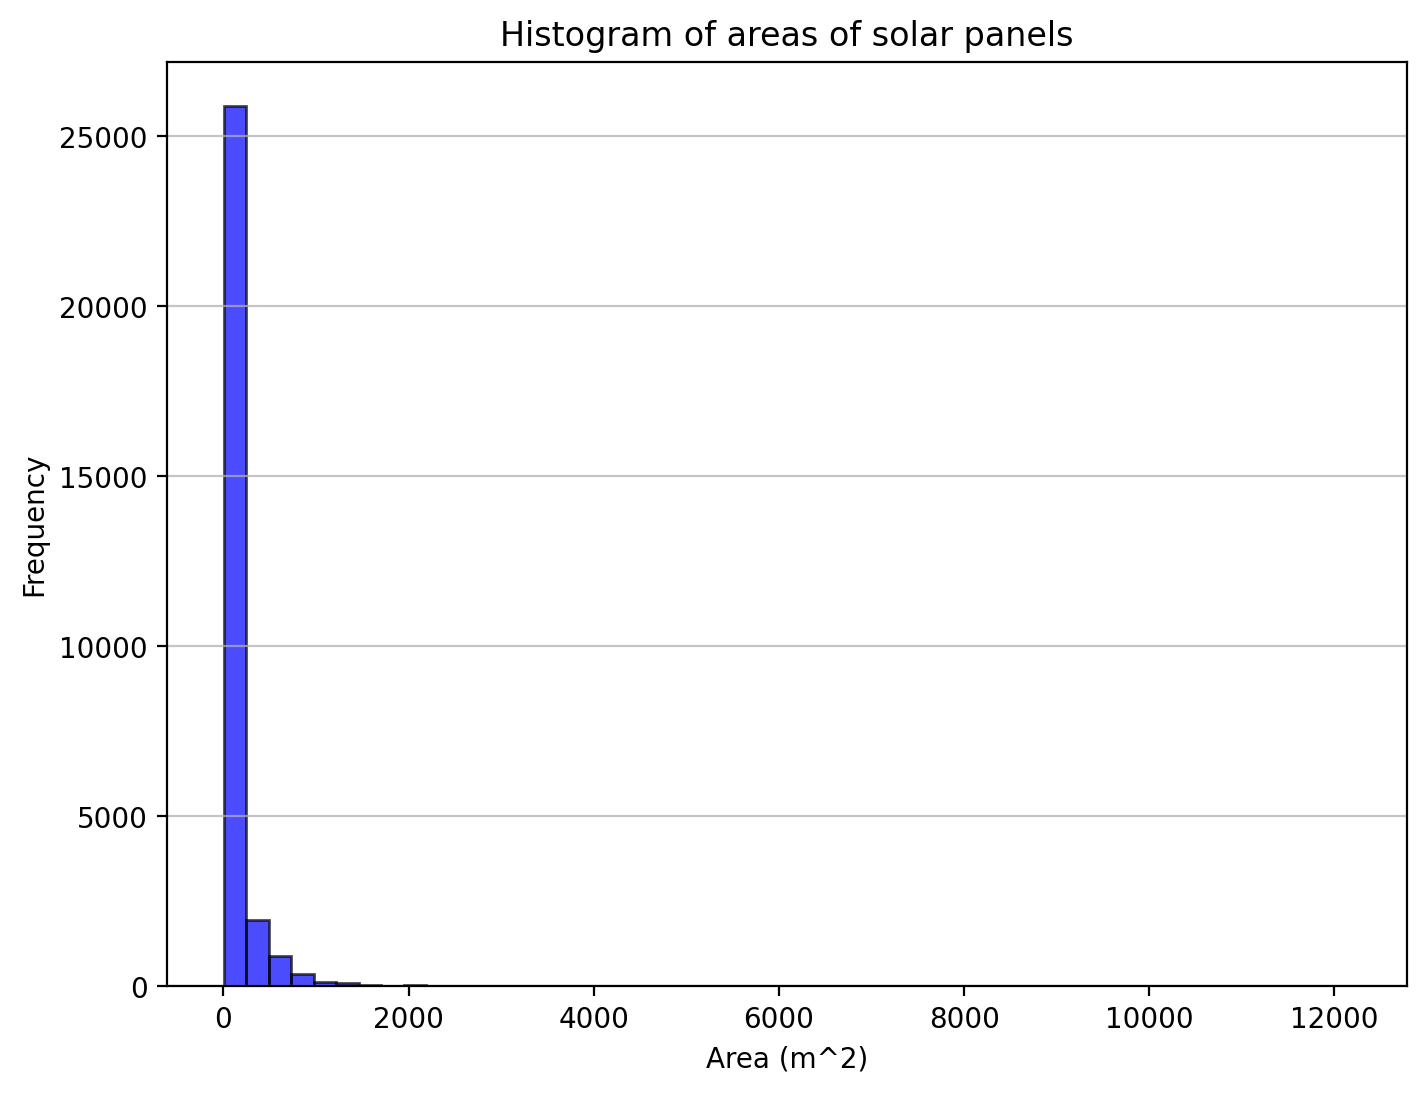

In [ ]:
areas = []
for label_name in label_names:
    label_path = os.path.join(label_dir, label_name)
    with open(label_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            class_name, x_center, y_center, width, height = map(float, line.split())
            # print(class_name, x_center, y_center, width, height)
            real_width = width * image_size * meters_per_pixel
            real_height = height * image_size * meters_per_pixel
            area = real_width * real_height
            areas.append(area)

areas = np.array(areas)
mean_area = np.mean(areas)
std_area = np.std(areas)
print(f'Mean area of solar panels: {mean_area:.2f} m^2')
print(f'Standard deviation of area of solar panels: {std_area:.2f} m^2')

plt.figure(figsize=(8, 6))
plt.hist(areas, bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Area (m^2)')
plt.ylabel('Frequency')
plt.title('Histogram of areas of solar panels')
plt.grid(axis='y', alpha=0.75)
plt.show()

From the above histogram, we can observe the following:

- The majority of the solar panels have areas concentrated around the lower end of the scale.
- There are fewer instances of solar panels with larger areas.
- The distribution appears to be right-skewed, indicating that most solar panels are relatively small in size, with a few larger ones.